### Importo tutte le librerie necessarie

In [1]:
import geopy
from geopy import distance #TODO BUGGONE
import math
import itertools
import pandas
import numpy
import networkx
from matplotlib import pyplot
import seaborn
%matplotlib inline

# Calcolo matrice adiacenza

### Calcolo il raggio medio che definisce Roma entro il raccordo anulare

NB: da verificare che distanza euclidea non crei troppi problemi

In [2]:
colosseo = (41.890173, 12.492331)
raccordo = [(41.914456, 12.615807),(41.990672, 12.502714),(41.793883, 12.511297),(41.812566, 12.396628),(41.956277, 12.384611)]
raggi = []

def geodesicDistance(A, B=colosseo):
    return geopy.distance.vincenty(A, B).meters

raggioTerra = 6372795
def euclidDistance(A, B=colosseo):
    latitudine1 = math.radians(A[0])
    latitudine2 = math.radians(B[0])
    longitudine1 = math.radians(A[1])
    longitudine2 = math.radians(B[1])
    x1 = raggioTerra*math.sin(math.pi-latitudine1)*math.cos(longitudine1)
    y1 = raggioTerra*math.sin(math.pi-latitudine1)*math.sin(longitudine1)
    z1 = raggioTerra*math.cos(math.pi-latitudine1)
    x2 = raggioTerra*math.sin(math.pi-latitudine2)*math.cos(longitudine2)
    y2 = raggioTerra*math.sin(math.pi-latitudine2)*math.sin(longitudine2)
    z2 = raggioTerra*math.cos(math.pi-latitudine2)
    return math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)


raggi = map(geodesicDistance, raccordo)
print raggi

raggi1= []
raggi1 = map(euclidDistance, raccordo)
print raggi1

raggiomedioGeo = 0
raggiomedioEuclid = 0
for i in raggi:
	raggiomedioGeo += i

for i in raggi1:
    raggiomedioEuclid += i
    
raggiomedioGeo /= len(raggi)
raggiomedioEuclid /= len(raggi1)


print raggiomedioGeo
print raggiomedioEuclid

[10594.771772886095, 11195.797051005826, 10810.334056716569, 11724.513790860976, 11565.06035260429]
[9561.666348445664, 11204.74314532015, 10802.028143952435, 11178.132568907718, 10869.268356548899]
11178.0954048
10723.1677126


### Popolo il dataframe e faccio una prima grossa scrematura

In [3]:
dataframe = pandas.read_csv("/home/protoss/Documenti/Siscomp_datas/data/cell_towers.csv")
#dataframe = pandas.read_csv("/home/protoss/Documenti/SistemiComplessi/data/cell_towers_diff-2016012100.csv")
#dataframe
criterioMCC = dataframe.mcc == 222
criterioMinsamples = dataframe.samples > 1
italydoitcleaner = dataframe[criterioMCC & criterioMinsamples]
italydoitcleaner

italydoitcleaner = italydoitcleaner.reset_index(drop=True)
italydoitcleaner.drop(italydoitcleaner.columns[[0, 1, 3, 5, 10, 11, 12, 13]], axis = 1, inplace=True)
#italydoitcleaner

### Seleziono le antenne in Roma e faccio dei .csv appositi

In [56]:
#inroma = pandas.DataFrame([[41.947416, 12.371001],
#                            [41.899392, 12.397436],
#                            [41.870510, 12.287917],
#                            [41.899648, 12.515196]], 
#                            columns=('lon', 'lat'))

#istruzione che fa selezione alcune righe con criteri su alcune colonne, 
#ne seleziona alcune e restituisce un array nompy di valori desiderati

coordinate = dataframe[criterioMCC & criterioMinsamples][['lat', 'lon']].values
#print coordinate


distanza = []
distanza = map(geodesicDistance, coordinate)

#print len(distanza)

#da approfondire
#italydoitcleaner['distanze'] = italydoitcleaner[['lat', 'lon']].map(lambda x: geodesicDistance())

italydoitcleaner['distanze'] = distanza
criterioRaccordo = italydoitcleaner.distanze < raggiomedioEuclid
romaCell = italydoitcleaner[criterioRaccordo]
romaCell = romaCell.reset_index(drop=True)
#romacellid
romaCell.to_csv("../data/Roma_towers.csv")

criterioTim = romaCell.net == 1
criterioWind = romaCell.net == 88
criterioVoda = romaCell.net == 10
criterioTre = romaCell.net == 99


timCell = romaCell[criterioTim]
timCell = timCell.reset_index(drop=True)
timCell.to_csv("../data/Tim_towers.csv")

windCell = romaCell[criterioWind]
windCell = windCell.reset_index(drop=True)
windCell.to_csv("../data/Wind_towers.csv")

vodaCell = romaCell[criterioVoda]
vodaCell = vodaCell.reset_index(drop=True)
vodaCell.to_csv("../data/Vodafone_towers.csv")

treCell = romaCell[criterioTre]
treCell = treCell.reset_index(True)
treCell.to_csv("../data/Tre_towers.csv")


Domande su iterazione su panda dataframe e efficienza, un tizio dice che la funzione iterrows è molto poco efficiente e sarebbe molto meglio usare un numpy array. Forse esistono funzioni più efficienti. 

http://stackoverflow.com/questions/10729210/iterating-row-by-row-through-a-pandas-dataframe  

http://stackoverflow.com/questions/7837722/what-is-the-most-efficient-way-to-loop-through-dataframes-with-pandas


### Prendo le antenne di Roma e faccio matrice adiacenza

In [57]:
#definisco la funzione che mi calcola la matrice di adiacenza
def matriceSupEuclid(datiCoordinate, datiRaggi):
    a = numpy.zeros((numdati,numdati), dtype=int)
    for i in xrange(numdati):
        for j in xrange(numdati-i-1):
            sommaraggi = datiRaggi[i] + datiRaggi[j+i+1]
            #è equivalente a un if 
            a[i,j+i+1] = a[j+i+1,i] = (euclidDistance(datiCoordinate[i], datiCoordinate[j+i+1]) <= 0.8*sommaraggi)
    return a

def matriceSupGeodetic(datiCoordinate, datiRaggi):
    a = numpy.zeros((numdati,numdati))
    for i in xrange(numdati):
        for j in xrange(numdati-i-1):
            if geodesicDistance(datiCoordinate[i], datiCoordinate[j+i+1]) <= datiRaggi[i] + datiRaggi[j+i+1]:
                a[i,j+i+1] = 1
                a[j+i+1,i] = 1
    return a



#dataframe = pandas.read_csv("../data/roma_towers.csv")
gestore = ["Roma", "Tim", "Vodafone", "Wind", "Tre"]
for aziende in gestore:
    dataframe = pandas.read_csv("../data/{0}_towers.csv".format(aziende))
    coordinate = dataframe[['lat', 'lon']].values
    raggio = dataframe['range'].values
    
#    for i in range(len(raggio)):
#        if(raggio[i] < 500):
#            raggio[i] = 500
    
    numdati = raggio.size
    
    #%time adiacenzaGeo = matriceSupGeodetic(coordinate, raggio)
    %time adiacenzaEuclid = matriceSupEuclid(coordinate, raggio)
    
    numpy.savetxt(("/home/protoss/Documenti/Siscomp_datas/data/AdiacenzaEuclidea_{0}.csv".format(aziende)),adiacenzaEuclid, fmt='%d',delimiter=',',newline='\n')

CPU times: user 1min 58s, sys: 704 ms, total: 1min 59s
Wall time: 1min 58s
CPU times: user 6.8 s, sys: 36 ms, total: 6.84 s
Wall time: 6.81 s
CPU times: user 6.46 s, sys: 32 ms, total: 6.5 s
Wall time: 6.46 s
CPU times: user 13.1 s, sys: 52 ms, total: 13.1 s
Wall time: 13.1 s
CPU times: user 4.75 s, sys: 32 ms, total: 4.78 s
Wall time: 4.75 s


## Faccio disegno grafo e grafico distr grado

In [58]:
#for azienda in gestore:

#italydoitcleaner['distanze'] = distanza
#romaCell.to_csv("../data/Roma_towers.csv")
adiacenzaRoma = numpy.genfromtxt("/home/protoss/Documenti/Siscomp_datas/data/AdiacenzaEuclidea_Roma.csv",delimiter=',',dtype='int')
adiacenzaTim = numpy.genfromtxt("/home/protoss/Documenti/Siscomp_datas/data/AdiacenzaEuclidea_Tim.csv",delimiter=',',dtype='int')
adiacenzaVoda = numpy.genfromtxt("/home/protoss/Documenti/Siscomp_datas/data/AdiacenzaEuclidea_Vodafone.csv",delimiter=',',dtype='int')
adiacenzaWind = numpy.genfromtxt("/home/protoss/Documenti/Siscomp_datas/data/AdiacenzaEuclidea_Wind.csv",delimiter=',',dtype='int')
adiacenzaTre = numpy.genfromtxt("/home/protoss/Documenti/Siscomp_datas/data/AdiacenzaEuclidea_Tre.csv",delimiter=',',dtype='int')

%time grafoRoma = networkx.Graph(adiacenzaRoma)
%time grafoTim = networkx.Graph(adiacenzaTim)
%time grafoVoda = networkx.Graph(adiacenzaVoda)
%time grafoWind = networkx.Graph(adiacenzaWind)
%time grafoTre = networkx.Graph(adiacenzaTre)


CPU times: user 5.64 s, sys: 124 ms, total: 5.77 s
Wall time: 5.76 s
CPU times: user 356 ms, sys: 0 ns, total: 356 ms
Wall time: 359 ms
CPU times: user 256 ms, sys: 4 ms, total: 260 ms
Wall time: 259 ms
CPU times: user 740 ms, sys: 0 ns, total: 740 ms
Wall time: 737 ms
CPU times: user 232 ms, sys: 12 ms, total: 244 ms
Wall time: 225 ms


In [59]:
print("num gradi Roma", networkx.number_of_nodes(grafoRoma))
print("num gradi Tim", networkx.number_of_nodes(grafoTim))
print("num gradi Vodafone", networkx.number_of_nodes(grafoVoda))
print("num gradi Wind", networkx.number_of_nodes(grafoWind))
print("num gradi Tre", networkx.number_of_nodes(grafoTre))

gradoRoma = grafoRoma.degree().values()
numpy.savetxt("../data/DistrGrado_Roma",gradoRoma,fmt='%d',newline='\n')
istoGradoRoma = networkx.degree_histogram(grafoRoma)
numpy.savetxt("../data/IstoGrado_Roma",istoGradoRoma,fmt='%d',newline='\n')
romaCell["grado"] = gradoRoma
romaCell.to_csv("../data/Roma_towers.csv")

gradoTim = grafoTim.degree().values()
numpy.savetxt("../data/DistrGrado_Tim",gradoTim,fmt='%d',newline='\n')
istoGradoTim = networkx.degree_histogram(grafoTim)
numpy.savetxt("../data/IstoGrado_Tim",istoGradoTim,fmt='%d',newline='\n')
timCell["grado"] = gradoTim
timCell.to_csv("../data/Tim_towers.csv")

gradoVoda = grafoVoda.degree().values()
numpy.savetxt("../data/DistrGrado_Vodafone",gradoVoda,fmt='%d',newline='\n')
istoGradoVoda = networkx.degree_histogram(grafoVoda)
numpy.savetxt("../data/IstoGrado_Voda",istoGradoVoda,fmt='%d',newline='\n')
vodaCell["grado"] = gradoVoda
vodaCell.to_csv("../data/Vodafone_towers.csv")

gradoWind = grafoWind.degree().values()
numpy.savetxt("../data/DistrGrado_Wind",gradoWind,fmt='%d',newline='\n')
istoGradoWind = networkx.degree_histogram(grafoWind)
numpy.savetxt("../data/IstoGrado_Wind",istoGradoWind,fmt='%d',newline='\n')
windCell["grado"] = gradoWind
windCell.to_csv("../data/Wind_towers.csv")

gradoTre = grafoTre.degree().values()
numpy.savetxt("../data/DistrGrado_Tre",gradoTre,fmt='%d',newline='\n')
istoGradoTre = networkx.degree_histogram(grafoTre)
numpy.savetxt("../data/IstoGrado_Tre",istoGradoTre,fmt='%d',newline='\n')
treCell["grado"] = gradoTre
treCell.to_csv("../data/Tre_towers.csv")


('num gradi Roma', 6571)
('num gradi Tim', 1550)
('num gradi Vodafone', 1531)
('num gradi Wind', 2175)
('num gradi Tre', 1315)


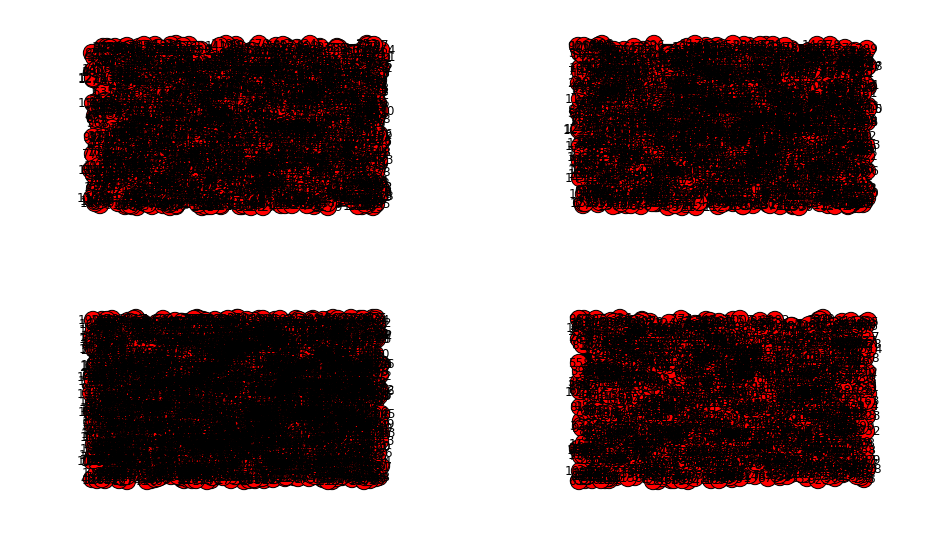

In [9]:
%matplotlib inline

pyplot.figure(figsize=(16,9))
pyplot.subplot(222)
networkx.draw_random(grafoTim)

pyplot.subplot(221)
networkx.draw_random(grafoVoda)

pyplot.subplot(223)
networkx.draw_random(grafoWind)

pyplot.subplot(224)
networkx.draw_random(grafoTre)

pyplot.show()

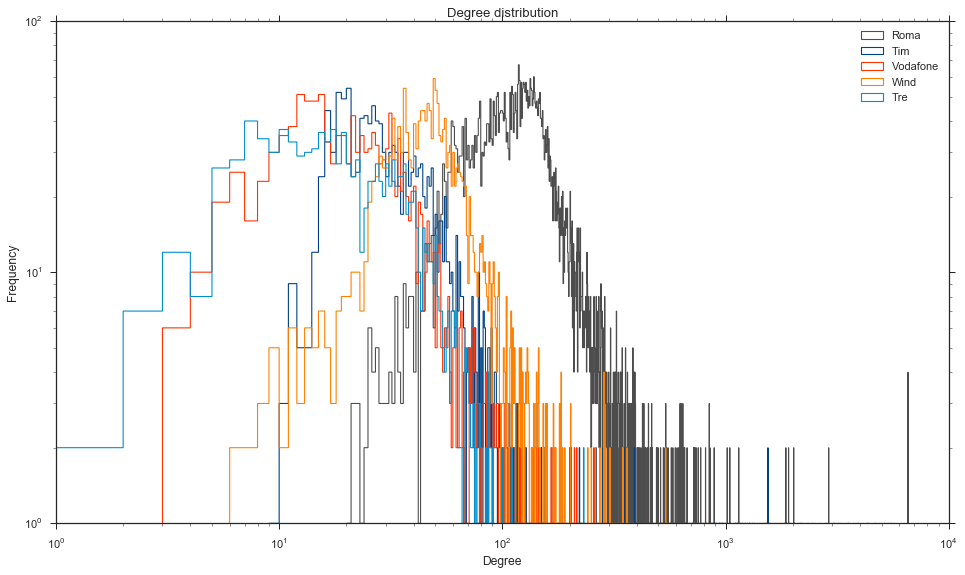

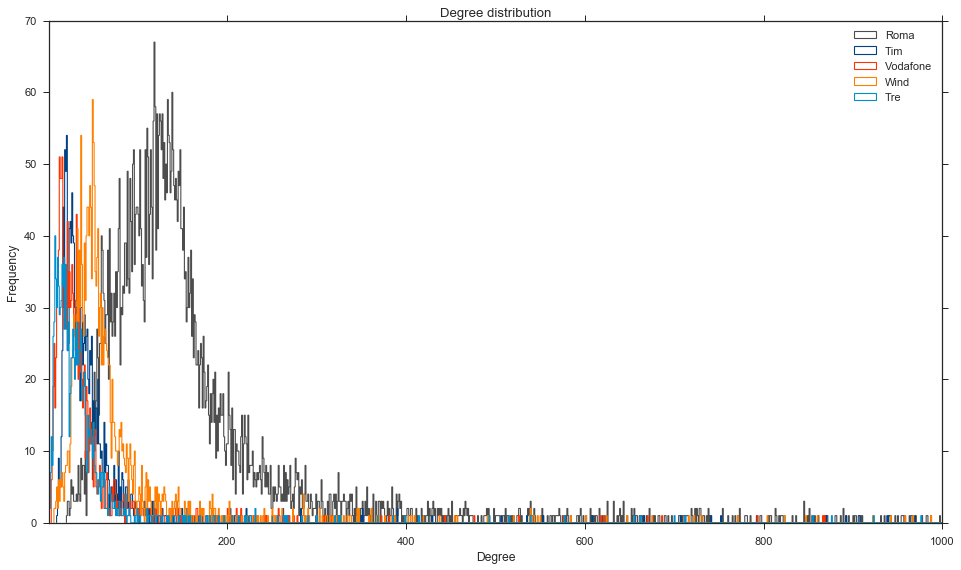

In [60]:
%matplotlib inline
gestore = ["Roma", "Tim", "Vodafone", "Wind", "Tre"]
colori = ['#4d4d4d', '#004184','#ff3300','#ff8000','#018ECC']
def degreeDistribution(gradi, azienda, colore):
    pyplot.hist(gradi, bins=max(gradi)-min(gradi), histtype='step', label=azienda, color=colore, linewidth=1.1)
    pyplot.title('Degree distribution')
    pyplot.xlabel("Degree")
    pyplot.ylabel("Frequency")

def degreeDistributionLog(gradi, azienda, colore):
    distribuzioneRange = pyplot.hist(gradi, bins=max(gradi)-min(gradi), histtype='step', label=azienda, color=colore, linewidth=1.1)
    pyplot.title('Degree distribution')
    pyplot.xlabel("Degree")
    pyplot.ylabel("Frequency")

    pyplot.gca().set_xscale("log")
    pyplot.gca().set_yscale("log")
#    pyplot.ylim(1,100)
    
pyplot.figure(figsize=(16,9))
distribuzione = degreeDistributionLog(gradoRoma, gestore[0], colori[0])
distribuzione = degreeDistributionLog(gradoTim, gestore[1], colori[1])
distribuzione = degreeDistributionLog(gradoVoda, gestore[2], colori[2])
distribuzione = degreeDistributionLog(gradoWind, gestore[3], colori[3])
distribuzione = degreeDistributionLog(gradoTre, gestore[4], colori[4])
#pyplot.xlim(1,1000)
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(16,9))
distribuzione = degreeDistribution(gradoRoma, gestore[0], colori[0])
distribuzione = degreeDistribution(gradoTim, gestore[1], colori[1])
distribuzione = degreeDistribution(gradoVoda, gestore[2], colori[2])
distribuzione = degreeDistribution(gradoWind, gestore[3], colori[3])
distribuzione = degreeDistribution(gradoTre, gestore[4], colori[4])
pyplot.xlim(1,1000)
pyplot.legend()
pyplot.show()

### Faccio istogramma del raggio delle antenne

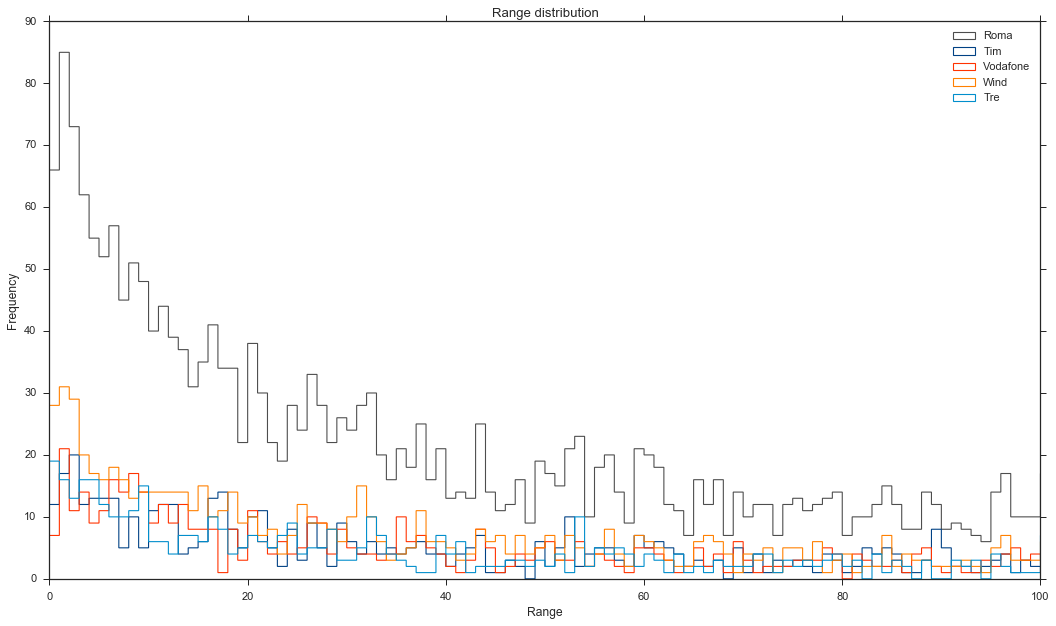

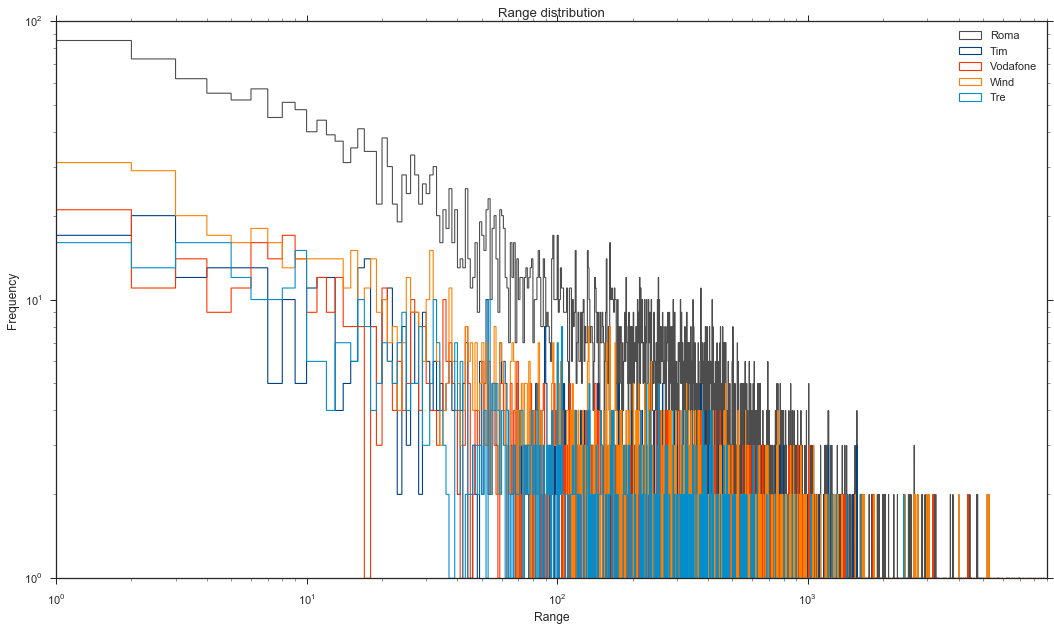

In [61]:
gestore = ["Roma", "Tim", "Vodafone", "Wind", "Tre"]
colori = ['#4d4d4d', '#004184','#ff3300','#ff8000','#018ECC']
def rangeDistribution(gradi, azienda, colore):
    pyplot.hist(gradi, bins=max(gradi)-min(gradi), histtype='step', label=azienda, color=colore, linewidth=1.1)
    pyplot.title('Range distribution')
    pyplot.xlabel("Range")
    pyplot.ylabel("Frequency")

def rangeDistributionLog(gradi, azienda, colore):
    distribuzioneRange = pyplot.hist(gradi, bins=max(gradi)-min(gradi), histtype='step', label=azienda, color=colore, linewidth=1.1)
    pyplot.title('Range distribution')
    pyplot.xlabel("Range")
    pyplot.ylabel("Frequency")

    pyplot.gca().set_xscale("log")
    pyplot.gca().set_yscale("log")

pyplot.figure(figsize=(16*1.11,9*1.11))
#gestore = ["Roma", "Tim", "Vodafone", "Wind", "Tre"]

for azienda, colore in zip(gestore,colori):
    dataframe = pandas.read_csv("../data/{0}_towers.csv".format(azienda))
    raggio = dataframe['range'].values
    distribuzione = rangeDistribution(raggio, azienda, colore)
#    print dataframe[dataframe.range == 0]
    pyplot.xlim(0,100)
    pyplot.legend()
pyplot.show()
    
pyplot.figure(figsize=(16*1.11,9*1.11))
for azienda, colore in zip(gestore,colori):
    dataframe = pandas.read_csv("../data/{0}_towers.csv".format(azienda))
    raggio = dataframe['range'].values
    distribuzione = rangeDistributionLog(raggio, azienda, colore)
#    print dataframe[dataframe.range == 0]
    pyplot.xlim(1,9000)
    pyplot.legend()
pyplot.show()

# USARE GRAPH TOOL
# VALUTARE USO METODI SPETTRALI TIPO PAGE RANK / BETWEENNESS; CERCARE SE SI DISCOSTANO DA DISTR GRADO NEL NOSTRO CASO DI RETE NON DIRETTA

NB. num antenne  
   * TIM - 1550  
   * Vodafone - 1531  
   * Wind - 2175   
   * 3 - 1315  
   
Tot antenne: 6571  

## TODO:  
* Prendere array coordinate   ✔
* fare array distanze          ✔
* mettere colonna distanze in dataframe  ✔
* selezionare righe con variabile compresa entro raggiomedio   ✔  
* fare un nuovo dataframe  ✔
* escludere tutti i nodi con 1 sample solo ✔
* fare P(k) ✔
* log binning  ✔
* FARE GRAFICI MEGLIO ✔
* Fare fit su P(k)
* variazione D con rimozione random o preferenziale ✔
* variazione GC con rimozione random o preferenziale ✔
* approfondire condizioni di soglia percolativa (v lez prof e articoli)
* barabasi e albert dicono che andamento giant cluster relativo è indipendente dalla dimensione della rete, non solo per reti scale free (frattali), ma anche per reti esponenziali! (frattali anch'esse?) Verificare sta cosa facendo confronto andamento GC tra rete totale e reti delle varie compagnie
* fare dei grafi barabasi e erdos e aggiungere quei grafi modellizzati a grafici di attacco e failure per fare confronto


NB giant cluster è cluster che scala con N.   
E.g., se il giant cluster è composto da N/10 della rete, se raddoppio la rete o la dimezzo deve rimanere composto da 1/10 del totale dei nodi della rete. Idem se è N/100 o N/0.9

  Leggere (materiale lezione su percolazione-attacchi-epidemie):  
  http://www.nature.com/nature/journal/v406/n6794/pdf/406378a0.pdf  
  http://arxiv.org/pdf/cond-mat/0010317.pdf  
  http://arxiv.org/pdf/cond-mat/0007048.pdf  
  http://arxiv.org/pdf/cond-mat/0010251.pdf  
  
  Altro materiale forse utile:  
  http://www.renyi.hu/~p_erdos/1959-11.pdf (Erdos e Renyi)  
  http://arxiv.org/pdf/cond-mat/0106096.pdf (Stat mec scale free network)  
  http://arxiv.org/pdf/cond-mat/9910332.pdf  
  http://arxiv.org/pdf/cond-mat/9907068.pdf  
  http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.71.8276&rep=rep1&type=pdf    
  
  Federico nota andamento range segua una sorta di legge di zipf, NOTA BENE, I NOSTRI DATI NON SONO DATI UFFICIALI, MA COSTRUITI DA GENTE CHE CAMMINA, QUINDI PROB DI TROVARE NUOVA ANTENNA POTREBBE ESSERE SIMILE A PROB TROVARE NUOVA PAROLA, ma io penso che non c'entri perché noi stiamo vedendo solo le lunghezze delle parole. Che legge regola la prob delle lunghezze delle parole?

Il primo tentativo è stato di fare la matrice di adiacenza a forza bruta. Con un campione di soli 50 nodi ci metteva pochi microsecondi, quindi abbiamo provato a fare la matrice di adiacenza delle 7000 antenne entro il raccordo anulare, notando che la compilazione durava tanto, facendo le dovute proporzioni abbiamo preventivato 2,5 ore di tempo di calcolo. La prima cosa che abbiamo sistemato è stato ovviamente fare un ciclo che calcolasse soltanto la metà superiore della matrice, dimezzando il tempo di calcolo. 

La prima cosa che abbiamo pensato di fare è stato di diagonalizzare a blocchi la matrice, o fare un ciclo di bassissimo livello che mettesse 0 a tutti gli elementi relativi alle antenne con $\Delta$Latitudine e/o $\Delta$Longitudine maggiori del range massimo del campione di dati. Il problema avuto è che il range delle antenne è tendenzialmente grande, con alcune che arrivano a 10km (con raggioRoma 11km)(e anche tanti samples), quindi non c'era modo di ridurre i calcoli. 

L'unica altra idea che abbiamo avuto è stata di non fare il calcolo complicato con la distanza sul geoide con il metodo vincenty. Primo passo è stato usare il metodo con great circles, l'altro è stato di considerare la porzione di Roma presa come un cerchio piano, calcolando quindi la distanza euclidea tra coordinate geografiche e convertendola in metri. E ci mette MOLTO meno tempo $\sim$10 volte in meno. Con un 
preventivo quindi di 10 minuti di tempo di calcolo invece di 1 ora e mezza.

TODO vedere parallelaizazione

## Varie note su tempi di calcolo

###Prova preliminare con 50 dati
con vincenti 
$\sim$45 ms

con great circols
$\sim$25 ms

con euclid
$\sim$5 ms

###Prova 50 dati

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.8 ms  
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.3 ms

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 33.6 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.2 ms

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.2 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.24 ms

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.29 ms

###Prova 100 dati

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 133 ms  
CPU times: user 12 ms, sys: 16 ms, total: 28 ms
Wall time: 21.5 ms

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 126 ms  
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16.6 ms

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 126 ms  
CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 21.9 ms

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 127 ms  
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.8 ms

###con 500

CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.27 s  
CPU times: user 404 ms, sys: 0 ns, total: 404 ms
Wall time: 403 ms

CPU times: user 3.26 s, sys: 20 ms, total: 3.28 s
Wall time: 3.23 s
CPU times: user 404 ms, sys: 0 ns, total: 404 ms
Wall time: 401 ms

###con 1000
CPU times: user 12.6 s, sys: 32 ms, total: 12.6 s
Wall time: 12.5 s
CPU times: user 1.62 s, sys: 16 ms, total: 1.64 s
Wall time: 1.62 s

CPU times: user 12.5 s, sys: 48 ms, total: 12.5 s
Wall time: 12.5 s
CPU times: user 1.62 s, sys: 16 ms, total: 1.64 s
Wall time: 1.62 s

###con 2000
CPU times: user 49.7 s, sys: 160 ms, total: 49.9 s
Wall time: 49.6 s  
CPU times: user 6.47 s, sys: 40 ms, total: 6.51 s
Wall time: 6.44 s

CPU times: user 51.2 s, sys: 232 ms, total: 51.4 s
Wall time: 51.1 s  
CPU times: user 6.67 s, sys: 24 ms, total: 6.7 s
Wall time: 6.65 s




###Geo dist
Tempo previsto di calcolo con $\sim$ 7000 dati: $\sim$ 620 sec $\sim$ 10 minuti

###Euclid dist
Tempo previsto di calcolo con $\sim$ 7000 dati: $\sim$ 80 sec $\sim$ 1,3 minuti

<function color_palette at 0x7f1f0c252758>


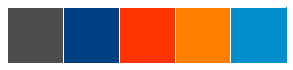

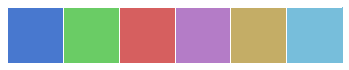

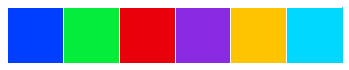

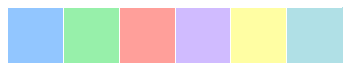

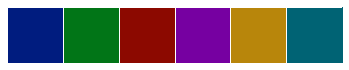

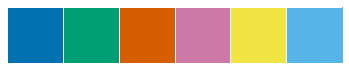

In [24]:
colori = ['#4d4d4d', '#004184','#ff3300','#ff8000','#018ECC']
paletta = seaborn.color_palette(palette = colori)
seaborn.palplot(paletta)
paletta = seaborn.color_palette(palette = 'muted')
seaborn.palplot(paletta)
paletta = seaborn.color_palette(palette = 'bright')
seaborn.palplot(paletta)
paletta = seaborn.color_palette(palette = 'pastel')
seaborn.palplot(paletta)
paletta = seaborn.color_palette(palette = 'dark')
seaborn.palplot(paletta)
paletta = seaborn.color_palette(palette = 'colorblind')
seaborn.palplot(paletta)


paletta = seaborn.color_palette
print paletta